In [2]:
!pip install split-folders

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
print(tf.__version__)

2.6.2


In [7]:
data_dir = '../input/brain-tumor-classification-mri'
batch_size=32
image_size=224

In [8]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.9008,0.0992))

Copying files: 2870 files [00:13, 208.45 files/s]


In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/train",
  shuffle=True,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 2583 files belonging to 4 classes.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/val",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 287 files belonging to 4 classes.


In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + "/Testing",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 394 files belonging to 4 classes.


In [14]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [15]:
class_names = test_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [16]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [17]:
normalization_layer1 = tf.keras.layers.Rescaling(1./255)
normalization_layer2 =  layer = tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], 
                      variance=[np.square(0.5), 
                                np.square(0.5), 
                                np.square(0.5)])

2022-06-11 21:02:20.161825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


-1.0 0.9992


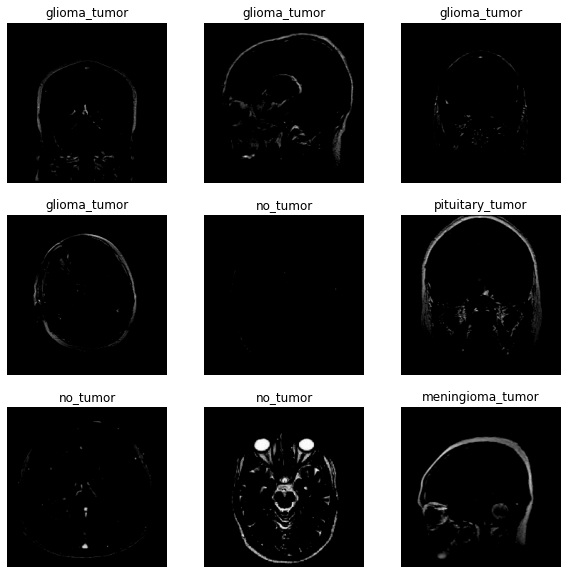

In [18]:
train_ds_normalized = train_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in train_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

-1.0 0.9992


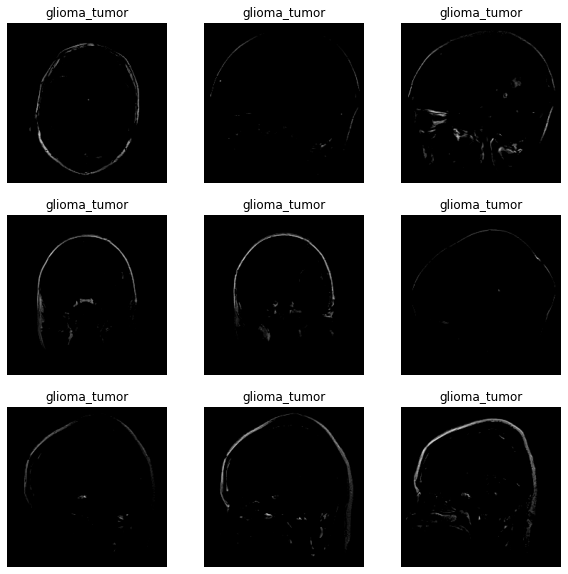

In [19]:
val_ds_normalized = val_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(val_ds_normalized))

print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in val_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

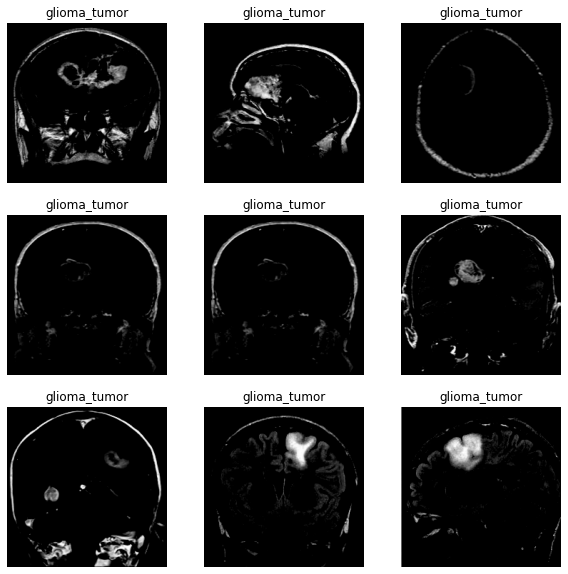

In [20]:
test_ds_normalized = test_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(test_ds_normalized))
plt.figure(figsize=(10, 10))
for images, labels in test_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
y_test = [label for images, labels in test_ds_normalized for label in labels.numpy()]

In [22]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Tensorflow and Keras')
   
    y_prediction = np.argmax(y_pred,axis=1)
    report = classification_report(y_test, y_prediction, target_names=class_names)
    print(f'{report}')

    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {model} Tensorflow and Keras')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)

In [23]:
def predict_image(y_pred):
    y_prediction = np.argmax(y_pred,axis=1)
    plt.figure(figsize=(25, 15))
    for idx,(images,labels) in enumerate(iter(test_ds)):
        ax = plt.subplot(3, 5, idx+1)
        plt.imshow(images[0].numpy()/255)
        plt.title(f'Label: {class_names[labels[0]]}\nPredicted: {class_names[y_prediction[idx*batch_size]]}\nProbability: {y_pred[idx*batch_size][y_prediction[idx*batch_size]]:.2f}', fontsize=10)
        plt.axis("off")

In [24]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                  "id": 1,
                  "variables":['accuracy', 'val_accuracy'],
                  "labels":['Training Accuracy', 'Validation Accuracy'],
                  "legend":'lower right',
                  "title":f'Accuracy Tensorflow and Keras - {model}',
                  "ylabel":'Accuracy'
              },{ 
                  "id": 2,
                  "variables":['loss', 'val_loss'],
                  "labels":['Training Loss', 'Validation Loss'],
                  "legend":'upper right',
                  "title":f'Loss Tensorflow and Keras - {model}',
                  "ylabel":'Loss'
              }]
    epochs_range = range(25)
    for tab in tab_plot: 
          plt.subplot(1, 2, tab['id'])
          plt.plot(epochs_range, history.history[tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
          plt.plot(epochs_range, history.history[tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
          plt.legend(loc=tab['legend'])
          plt.title(tab['title'])
          plt.xlabel('Epochs')
          plt.ylabel(tab['ylabel'])
    plt.show()

In [25]:
from tensorflow.keras.applications import MobileNetV2 
mobilenet =  MobileNetV2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3),alpha=1)

9420800/9406464 [==============================] - 0s 0us/step


In [26]:
model = mobilenet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=mobilenet.input, outputs = model)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [28]:
print('Train Mobilenetv2 Tensorflow and Keras')
history_mobilenet_v2 = model.fit(train_ds_normalized,  validation_data=(val_ds_normalized), epochs=1)

Train Mobilenetv2 Tensorflow and Keras


2022-06-11 21:02:58.869150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


81/81 [==============================] - 27s 195ms/step - loss: 0.4800 - accuracy: 0.8393 - val_loss: 7.9375 - val_accuracy: 0.4425


Test Mobilenetv2 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.78      0.25      0.38       100
meningioma_tumor       0.61      0.15      0.24       115
        no_tumor       0.31      0.97      0.46       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.37       394
       macro avg       0.42      0.34      0.27       394
    weighted avg       0.46      0.37      0.29       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


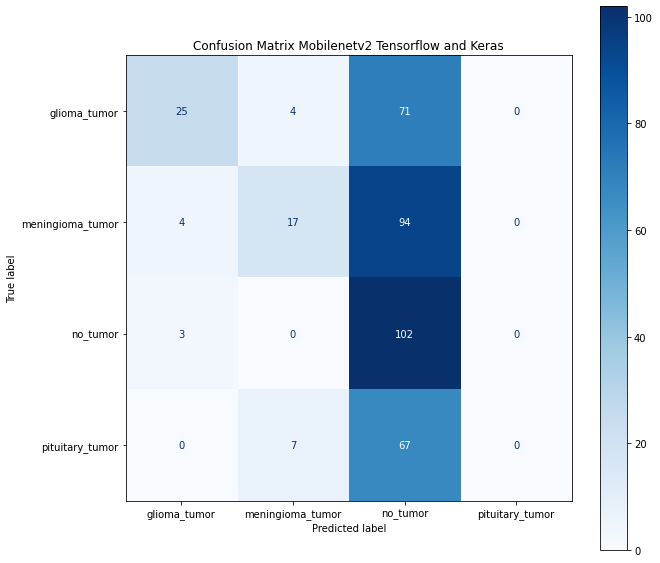

In [30]:
y_pred_mobilenet_v2 = model.predict(test_ds_normalized)
display_report_and_matrix(y_pred_mobilenet_v2, 'Mobilenetv2')

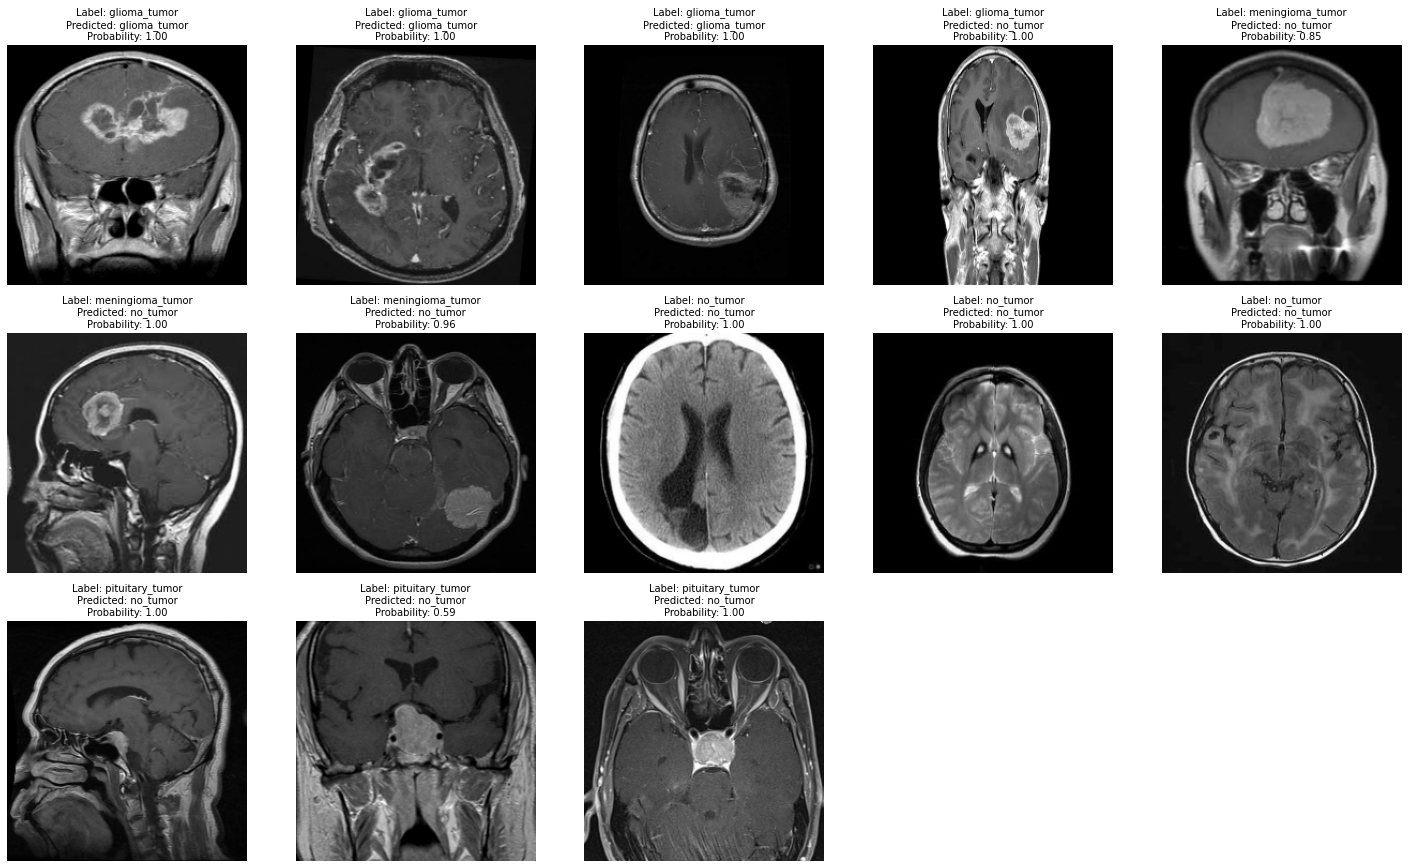

In [31]:
predict_image(y_pred_mobilenet_v2)

In [32]:
from tensorflow.keras.applications import DenseNet121 #EfficientNetB0 
dense =  DenseNet121(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

29097984/29084464 [==============================] - 0s 0us/step


In [33]:
model_densenet = dense.output
model_densenet = tf.keras.layers.GlobalAveragePooling2D()(model_densenet)
model_densenet = tf.keras.layers.Dense(4,activation='softmax')(model_densenet)
model_densenet = tf.keras.models.Model(inputs=dense.input, outputs = model_densenet)

In [34]:
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [35]:
print('Train DenseNet121 Tensorflow and Keras')
history_densenet = model_densenet.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=1)

Train DenseNet121 Tensorflow and Keras
81/81 [==============================] - 32s 255ms/step - loss: 0.4447 - accuracy: 0.8382 - val_loss: 2.0838 - val_accuracy: 0.6690


Test DenseNet121 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.83      0.20      0.32       100
meningioma_tumor       0.41      0.98      0.57       115
        no_tumor       0.75      0.65      0.69       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.51       394
       macro avg       0.50      0.46      0.40       394
    weighted avg       0.53      0.51      0.43       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


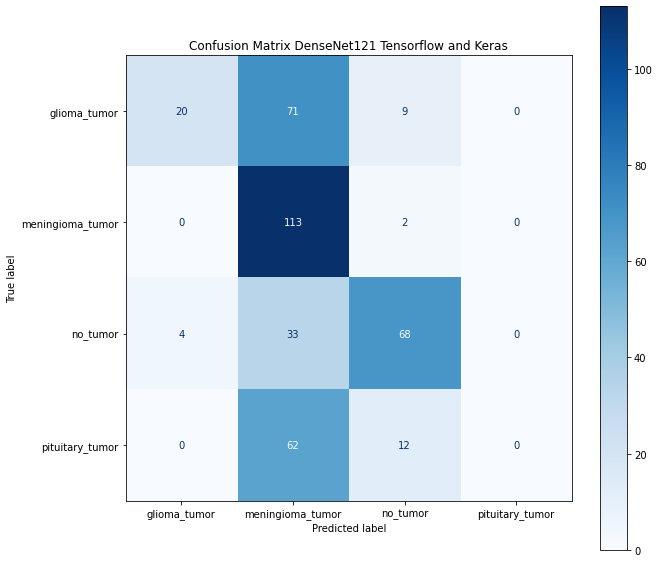

In [36]:
y_pred_densenet = model_densenet.predict(test_ds_normalized)
display_report_and_matrix(y_pred_densenet, 'DenseNet121')

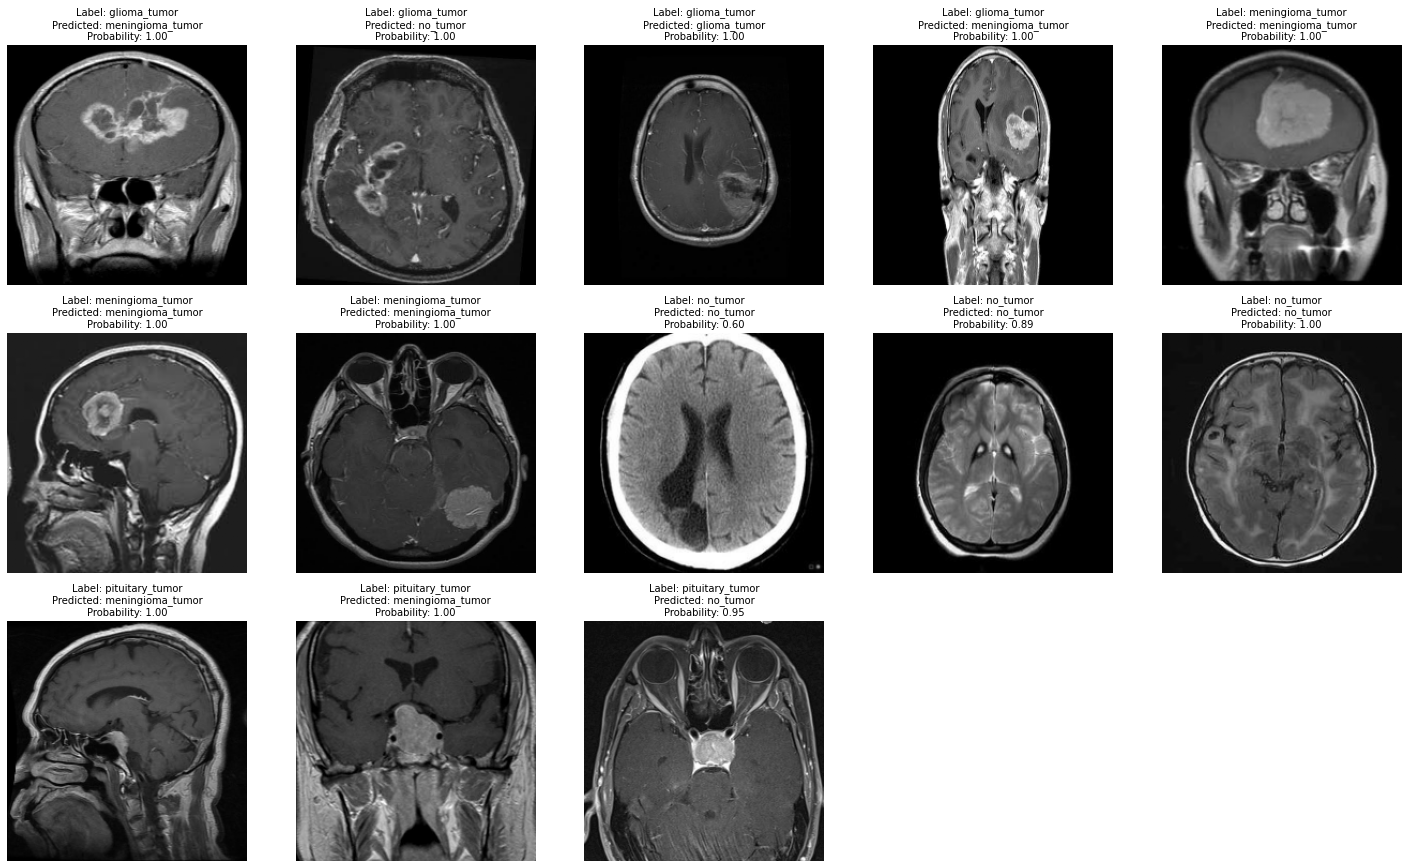

In [37]:
predict_image(y_pred_densenet)

In [42]:
from tensorflow.keras.applications import ResNet50
resnet =  ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [43]:
model_resnet50 = resnet.output
model_resnet50 = tf.keras.layers.GlobalAveragePooling2D()(model_resnet50)
model_resnet50 = tf.keras.layers.Dense(4,activation='softmax')(model_resnet50)
model_resnet50 = tf.keras.models.Model(inputs=resnet.input, outputs = model_resnet50)

In [44]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [45]:
print('Train Resnet50 Tensorflow and Keras')
history_resnet50 = model_resnet50.fit(train_ds_normalized, validation_data=val_ds_normalized, epochs=25)

Train Resnet50 Tensorflow and Keras
Epoch 1/25
81/81 [==============================] - 21s 194ms/step - loss: 0.6716 - accuracy: 0.7855 - val_loss: 98.0483 - val_accuracy: 0.2892
Epoch 2/25
81/81 [==============================] - 16s 188ms/step - loss: 0.2551 - accuracy: 0.9164 - val_loss: 6.9138 - val_accuracy: 0.1394
Epoch 3/25
81/81 [==============================] - 16s 190ms/step - loss: 0.1754 - accuracy: 0.9404 - val_loss: 3.9931 - val_accuracy: 0.1394
Epoch 4/25
81/81 [==============================] - 15s 186ms/step - loss: 0.0994 - accuracy: 0.9663 - val_loss: 6.2372 - val_accuracy: 0.1394
Epoch 5/25
81/81 [==============================] - 16s 188ms/step - loss: 0.1204 - accuracy: 0.9621 - val_loss: 4.8328 - val_accuracy: 0.1394
Epoch 6/25
81/81 [==============================] - 16s 186ms/step - loss: 0.0534 - accuracy: 0.9837 - val_loss: 5.0583 - val_accuracy: 0.1394
Epoch 7/25
81/81 [==============================] - 16s 190ms/step - loss: 0.0621 - accuracy: 0.9837 - va

Test ResNet50 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.18      0.31       100
meningioma_tumor       0.70      0.99      0.82       115
        no_tumor       0.69      1.00      0.82       105
 pituitary_tumor       0.97      0.80      0.87        74

        accuracy                           0.75       394
       macro avg       0.84      0.74      0.70       394
    weighted avg       0.82      0.75      0.70       394



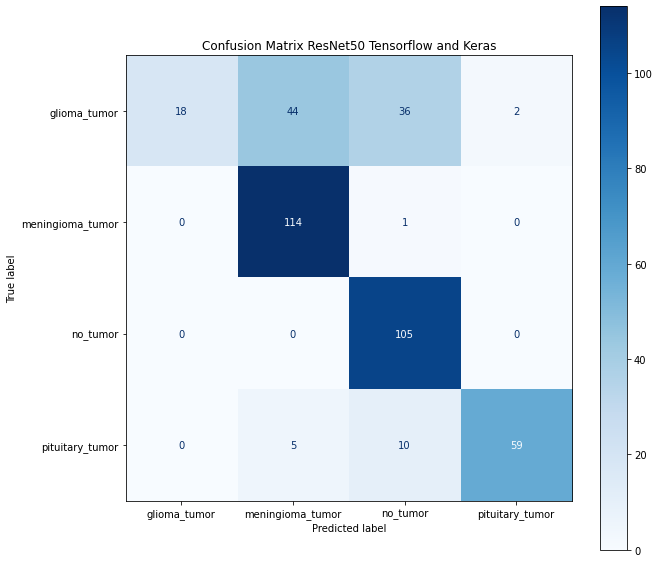

In [46]:
y_pred_resnet50 = model_resnet50.predict(test_ds_normalized)
display_report_and_matrix(y_pred_resnet50, 'ResNet50')

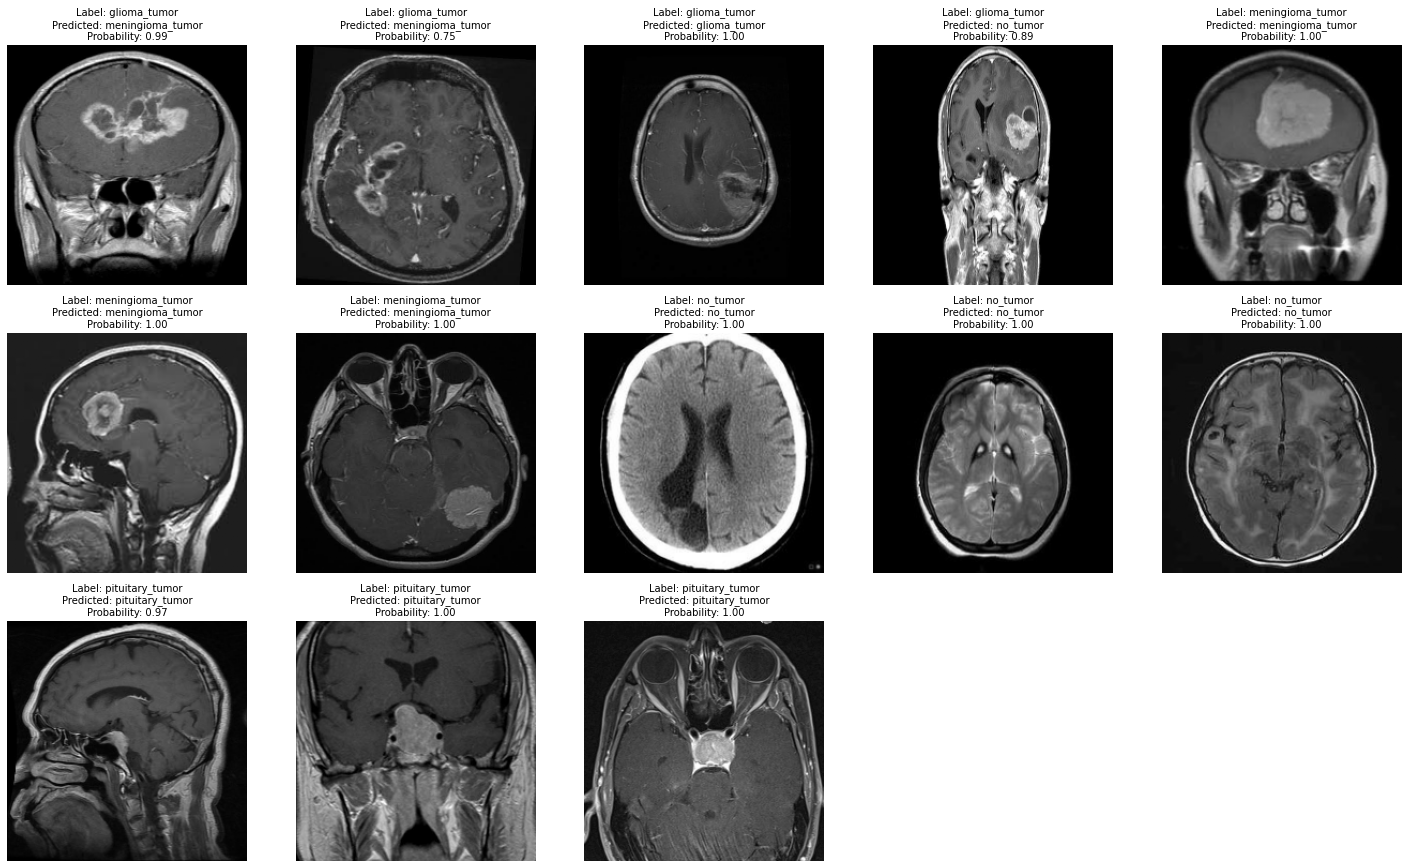

In [47]:
predict_image(y_pred_resnet50)